# 深度学习模型
特征：
1. 滑动窗口采样
设置windows size，采样前k个step预测下一个

2. 滑动窗口平均采样

模型：
1. MLP
2. CNN
3. LSTM
4. RCNN
5. RWKV

todo：
1. 加入额外特征embedding

In [1]:
import pandas as pd
import numpy as np
import random
import pickle
import math
import os
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
from dataclasses import dataclass

# 1 读取处理后数据

字典数据：
```
{
    'tid':[
        [cycle_count],
        [battery_life]
    ]
}
```

DataFrame数据：
```
columns = [tid,cycle_count,life]
```

In [3]:
bmap = pickle.load(open("../data/processed/nasa-li-battery_dict_240906.pkl",'rb'))

In [4]:
# ddf = pd.read_pickle('../data/processed/nasa-li-battery_df_240906.pkl')

# 2 特征采样和评价指标

## 2.1 特征采样

In [5]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8, train_ratio=0.):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    

def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re

## 2.2 训练和评价

In [6]:
from tqdm import tqdm

### 绘图函数

In [7]:
def plot(name,
         real_data, 
         pred_data):
    fig, ax = plt.subplots(1, figsize=(12, 8))

    plot_range = [i for i in range(len(real_data))]
    
    ax.plot(plot_range, real_data, 'b.', label=name)
    ax.plot(plot_range, pred_data, 'r.', label='Prediction')
    plt.plot([-1,170],[2*0.7, 2*0.7], c='black', lw=1, ls='--')  # 临界点直线
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
    plt.legend()

# 3 RNN

RNN取最后一个step接linear输出。

后续可考虑LSTM和attention。

In [8]:
from typing import List,Dict,Tuple

In [9]:
from collections import OrderedDict

In [10]:
import torch

In [11]:
class NASALiBatteryDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 fpath:str,
                ):
        
        x_lst,y_lst = [],[]
        self.data_dict = pickle.load(open(fpath,'rb'))
        for name in self.data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(self.data_dict, name, window_size)
            real_train_y = np.expand_dims(train_y[:,-1],-1)
            x_lst.append(train_x)
            y_lst.append(real_train_y)
        self.train_x = np.vstack(x_lst)
        self.train_y = np.vstack(y_lst)
        
    def __len__(self):
        return self.train_x.shape[0]
        
    def __getitem__(self, indices):
        
        return np.take(self.train_x,axis=0,indices=indices), np.take(self.train_y,axis=0,indices=indices)

In [12]:
class BaseModel(torch.nn.Module):

    def __init__(self, 
                 prefix_length:int=1,
                 device:str='cpu'):
        super(BaseModel, self).__init__()
        
        self.prefix_length = prefix_length
        self.device = device
    def __post_init__(self):
        self.double()
        
    def decode(self,
               input_x:np.array,
               max_length:int):
        '''
        input_x: List(prefix_length, )
        max_length: target decode length
        '''
        if not self.prefix_length != len(input_x):
            assert(f'Error input sequence must be prefix_length shape:{self.prefix_length}')

        test_x = input_x
        
        # decode to target length
        for i in range(max_length+1):
            online_x = np.array(test_x[-self.prefix_length:])
            online_x = torch.tensor(online_x).reshape((1,online_x.shape[0])).double().to(self.device)
            test_x += self.forward(online_x).flatten().detach().numpy().tolist() #测试值加入原来序列用来继续预测下一个点

        # list
        return test_x
        
    def forward(self, 
                x:torch.Tensor):
        '''
        x: (prefix_length, )
        '''
        pass

In [13]:
rnnlayer = torch.nn.RNN(input_size=1,
                        hidden_size=1,
                        num_layers=4,
                        batch_first=True,
                        dropout=0.5,
                        bidirectional=True)

In [47]:
class RNNModel(BaseModel):

    def __init__(self,
                 feature_size:int,
                 num_layers:int=1,
                 prefix_length:int=1,
                 device:str='cpu'):
        super(RNNModel, self).__init__(
            prefix_length=prefix_length,
               device=device
        )

        # 只有一个channel 所以默认input_size和hidden_size为1，没啥需要设置的参数
        self.RNNLayer = rnnlayer = torch.nn.RNN(input_size=1,
                                                hidden_size=self.prefix_length,
                                                num_layers=num_layers,
                                                batch_first=True,
                                                dropout=0.5,
                                                bidirectional=False)
        
        self.OutLinearLayer = torch.nn.Linear(in_features=self.prefix_length,
                                              out_features=1)
        
        self.__post_init__()
    def forward(self,
                x:torch.Tensor):
        x = x.reshape(x.shape[0],x.shape[1],1)
        
        out, _ = self.RNNLayer(x)       # out shape: (batch_size, feature_size, hidden_dim)
        out = out[:, -1, :]         # 取序列最后一个时间步的输出作为预测  
        out = self.OutLinearLayer(out)      # out shape: (batch_size, 1)
        
        return out

In [48]:
window_size = 32
epoch = 10_00_000
learning_rate = 1e-4    # learning rate
weight_decay = 0.0
feature_size = 16
num_layers = 2
batch_size = 512

In [49]:
eval_step = 1000

In [50]:
data_dict = bmap

In [51]:
model = RNNModel(feature_size=feature_size,
                 num_layers=num_layers,
                 prefix_length=window_size)

In [52]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

In [53]:
on_test_log = True

In [54]:
train_dataset = NASALiBatteryDataset(fpath='../data/processed/nasa-li-battery_dict_240906.pkl')

In [55]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)

In [56]:
loss_list = [0]
mae_lst,rmse_lst = [], []

for i in tqdm(range(epoch)):
    if i%eval_step==0 and on_test_log:
        print('---------------------------------------------------')
    for batch_x,batch_y in train_loader:
        output= model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()              # clear gradients for this training step
        loss.backward()                    # backpropagation, compute gradients
        optimizer.step()                   # apply gradients

        loss_list.append(loss.detach().numpy().tolist())

    if i%eval_step==0:
        for name in data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)
            
            prefix_x = data_dict[name][1][:window_size]
            decode_seq = model.decode(prefix_x,max_length=len(test_data))[window_size+1:]
            mae, rmse = evaluation(y_test=test_data, y_predict=decode_seq)
            
            mae_lst.append(mae)
            rmse_lst.append(rmse)
        
        if on_test_log:
            print(f'Epoch:{i} Loss:{np.average(loss_list):.8f} MAE:{np.average(mae_lst):.4f} | RMSE:{np.average(rmse_lst):.4f}')

  0%|          | 0/1000000 [00:00<?, ?it/s]

---------------------------------------------------


  0%|          | 4/1000000 [00:00<30:03:02,  9.24it/s] 

Epoch:0 Loss:1.20056200 MAE:1.3327 | RMSE:1.3423


  0%|          | 1000/1000000 [00:44<12:47:10, 21.70it/s]

---------------------------------------------------


  0%|          | 1003/1000000 [00:45<22:26:56, 12.36it/s]

Epoch:1000 Loss:0.03988567 MAE:0.7067 | RMSE:0.7189


  0%|          | 1999/1000000 [01:29<12:52:48, 21.52it/s]

---------------------------------------------------


  0%|          | 2005/1000000 [01:30<20:17:09, 13.67it/s]

Epoch:2000 Loss:0.02055274 MAE:0.4940 | RMSE:0.5045


  0%|          | 2998/1000000 [02:14<12:17:18, 22.54it/s]

---------------------------------------------------


  0%|          | 3004/1000000 [02:15<19:10:33, 14.44it/s]

Epoch:3000 Loss:0.01398666 MAE:0.3847 | RMSE:0.3944


  0%|          | 4000/1000000 [02:59<11:35:55, 23.85it/s]

---------------------------------------------------


  0%|          | 4003/1000000 [03:00<22:00:33, 12.57it/s]

Epoch:4000 Loss:0.01065401 MAE:0.3197 | RMSE:0.3294


  0%|          | 4999/1000000 [03:44<12:19:07, 22.44it/s]

---------------------------------------------------


  1%|          | 5005/1000000 [03:45<18:55:20, 14.61it/s]

Epoch:5000 Loss:0.00862884 MAE:0.2748 | RMSE:0.2841


  1%|          | 5998/1000000 [04:29<12:27:55, 22.15it/s]

---------------------------------------------------


  1%|          | 6004/1000000 [04:30<18:22:04, 15.03it/s]

Epoch:6000 Loss:0.00726770 MAE:0.2440 | RMSE:0.2529


  1%|          | 7000/1000000 [05:14<11:39:51, 23.65it/s]

---------------------------------------------------


  1%|          | 7003/1000000 [05:15<22:01:39, 12.52it/s]

Epoch:7000 Loss:0.00629123 MAE:0.2203 | RMSE:0.2290


  1%|          | 7999/1000000 [05:59<12:40:17, 21.75it/s]

---------------------------------------------------


  1%|          | 8005/1000000 [06:00<19:14:53, 14.32it/s]

Epoch:8000 Loss:0.00555709 MAE:0.2056 | RMSE:0.2142


  1%|          | 8999/1000000 [06:44<12:14:32, 22.49it/s]

---------------------------------------------------


  1%|          | 9005/1000000 [06:45<18:39:05, 14.76it/s]

Epoch:9000 Loss:0.00498511 MAE:0.1908 | RMSE:0.1991


  1%|          | 9998/1000000 [07:29<12:09:45, 22.61it/s]

---------------------------------------------------


  1%|          | 10003/1000000 [07:30<19:49:42, 13.87it/s]

Epoch:10000 Loss:0.00452675 MAE:0.1806 | RMSE:0.1890


  1%|          | 10999/1000000 [08:14<12:16:22, 22.38it/s]

---------------------------------------------------


  1%|          | 11005/1000000 [08:15<19:33:24, 14.05it/s]

Epoch:11000 Loss:0.00415117 MAE:0.1706 | RMSE:0.1789


  1%|          | 11998/1000000 [08:59<12:06:36, 22.66it/s]

---------------------------------------------------


  1%|          | 12004/1000000 [09:00<18:51:33, 14.55it/s]

Epoch:12000 Loss:0.00383775 MAE:0.1633 | RMSE:0.1720


  1%|▏         | 13000/1000000 [09:44<13:11:24, 20.79it/s]

---------------------------------------------------


  1%|▏         | 13003/1000000 [09:44<24:07:01, 11.37it/s]

Epoch:13000 Loss:0.00357227 MAE:0.1564 | RMSE:0.1650


  1%|▏         | 13998/1000000 [10:29<12:08:03, 22.57it/s]

---------------------------------------------------


  1%|▏         | 14004/1000000 [10:29<19:37:03, 13.96it/s]

Epoch:14000 Loss:0.00334448 MAE:0.1494 | RMSE:0.1579


  2%|▏         | 15000/1000000 [11:14<12:04:39, 22.65it/s]

---------------------------------------------------


  2%|▏         | 15003/1000000 [11:14<22:09:39, 12.35it/s]

Epoch:15000 Loss:0.00314675 MAE:0.1453 | RMSE:0.1540


  2%|▏         | 15999/1000000 [11:59<12:10:23, 22.45it/s]

---------------------------------------------------


  2%|▏         | 16005/1000000 [11:59<19:06:47, 14.30it/s]

Epoch:16000 Loss:0.00297357 MAE:0.1399 | RMSE:0.1485


  2%|▏         | 16998/1000000 [12:43<12:04:00, 22.63it/s]

---------------------------------------------------


  2%|▏         | 17004/1000000 [12:44<18:27:39, 14.79it/s]

Epoch:17000 Loss:0.00282056 MAE:0.1347 | RMSE:0.1432


  2%|▏         | 18000/1000000 [13:28<12:44:09, 21.42it/s]

---------------------------------------------------


  2%|▏         | 18003/1000000 [13:29<23:02:41, 11.84it/s]

Epoch:18000 Loss:0.00268432 MAE:0.1316 | RMSE:0.1401


  2%|▏         | 18999/1000000 [14:14<12:25:48, 21.92it/s]

---------------------------------------------------


  2%|▏         | 19005/1000000 [14:14<19:40:37, 13.85it/s]

Epoch:19000 Loss:0.00256228 MAE:0.1279 | RMSE:0.1364


  2%|▏         | 20000/1000000 [15:00<12:07:49, 22.44it/s]

---------------------------------------------------


  2%|▏         | 20003/1000000 [15:00<21:44:26, 12.52it/s]

Epoch:20000 Loss:0.00245234 MAE:0.1244 | RMSE:0.1328


  2%|▏         | 21000/1000000 [15:47<13:03:03, 20.84it/s]

---------------------------------------------------


  2%|▏         | 21003/1000000 [15:47<23:39:25, 11.50it/s]

Epoch:21000 Loss:0.00235277 MAE:0.1220 | RMSE:0.1304


  2%|▏         | 21998/1000000 [16:33<11:54:25, 22.82it/s]

---------------------------------------------------


  2%|▏         | 22004/1000000 [16:33<18:55:07, 14.36it/s]

Epoch:22000 Loss:0.00226218 MAE:0.1196 | RMSE:0.1281


  2%|▏         | 23000/1000000 [17:18<12:37:03, 21.51it/s]

---------------------------------------------------


  2%|▏         | 23003/1000000 [17:18<21:35:47, 12.57it/s]

Epoch:23000 Loss:0.00217939 MAE:0.1182 | RMSE:0.1268


  2%|▏         | 23999/1000000 [18:03<12:14:04, 22.16it/s]

---------------------------------------------------


  2%|▏         | 24005/1000000 [18:03<18:26:45, 14.70it/s]

Epoch:24000 Loss:0.00210342 MAE:0.1161 | RMSE:0.1247


  2%|▏         | 24998/1000000 [18:47<11:43:20, 23.10it/s]

---------------------------------------------------


  3%|▎         | 25004/1000000 [18:48<19:05:47, 14.18it/s]

Epoch:25000 Loss:0.00203345 MAE:0.1137 | RMSE:0.1223


  3%|▎         | 26000/1000000 [19:32<11:57:25, 22.63it/s]

---------------------------------------------------


  3%|▎         | 26003/1000000 [19:33<21:32:13, 12.56it/s]

Epoch:26000 Loss:0.00196883 MAE:0.1117 | RMSE:0.1202


  3%|▎         | 26999/1000000 [20:17<11:48:18, 22.90it/s]

---------------------------------------------------


  3%|▎         | 27005/1000000 [20:18<18:24:10, 14.69it/s]

Epoch:27000 Loss:0.00190893 MAE:0.1097 | RMSE:0.1182


  3%|▎         | 27998/1000000 [21:02<11:36:06, 23.27it/s]

---------------------------------------------------


  3%|▎         | 28004/1000000 [21:03<18:49:27, 14.34it/s]

Epoch:28000 Loss:0.00185328 MAE:0.1075 | RMSE:0.1160


  3%|▎         | 29000/1000000 [21:47<11:54:39, 22.64it/s]

---------------------------------------------------


  3%|▎         | 29003/1000000 [21:47<22:17:36, 12.10it/s]

Epoch:29000 Loss:0.00180140 MAE:0.1055 | RMSE:0.1140


  3%|▎         | 29998/1000000 [22:32<11:47:14, 22.86it/s]

---------------------------------------------------


  3%|▎         | 30004/1000000 [22:32<19:48:47, 13.60it/s]

Epoch:30000 Loss:0.00175295 MAE:0.1037 | RMSE:0.1122


  3%|▎         | 31000/1000000 [23:17<12:00:01, 22.43it/s]

---------------------------------------------------


  3%|▎         | 31003/1000000 [23:17<21:55:22, 12.28it/s]

Epoch:31000 Loss:0.00170758 MAE:0.1020 | RMSE:0.1105


  3%|▎         | 31999/1000000 [24:01<11:58:32, 22.45it/s]

---------------------------------------------------


  3%|▎         | 32005/1000000 [24:02<18:31:10, 14.52it/s]

Epoch:32000 Loss:0.00166502 MAE:0.1003 | RMSE:0.1087


  3%|▎         | 32998/1000000 [24:47<12:09:13, 22.10it/s]

---------------------------------------------------


  3%|▎         | 33004/1000000 [24:47<18:22:32, 14.62it/s]

Epoch:33000 Loss:0.00162502 MAE:0.0987 | RMSE:0.1071


  3%|▎         | 34000/1000000 [25:32<12:02:42, 22.28it/s]

---------------------------------------------------


  3%|▎         | 34003/1000000 [25:32<21:36:34, 12.42it/s]

Epoch:34000 Loss:0.00158735 MAE:0.0970 | RMSE:0.1055


  3%|▎         | 34999/1000000 [26:16<12:17:10, 21.82it/s]

---------------------------------------------------


  4%|▎         | 35005/1000000 [26:17<19:59:25, 13.41it/s]

Epoch:35000 Loss:0.00155182 MAE:0.0960 | RMSE:0.1044


  4%|▎         | 35998/1000000 [27:01<11:47:07, 22.72it/s]

---------------------------------------------------


  4%|▎         | 36004/1000000 [27:02<19:15:37, 13.90it/s]

Epoch:36000 Loss:0.00151821 MAE:0.0948 | RMSE:0.1033


  4%|▎         | 37000/1000000 [27:46<11:06:11, 24.09it/s]

---------------------------------------------------


  4%|▎         | 37003/1000000 [27:47<21:12:01, 12.62it/s]

Epoch:37000 Loss:0.00148641 MAE:0.0937 | RMSE:0.1022


  4%|▍         | 37999/1000000 [28:31<12:17:50, 21.73it/s]

---------------------------------------------------


  4%|▍         | 38002/1000000 [28:32<22:25:41, 11.91it/s]

Epoch:38000 Loss:0.00145628 MAE:0.0928 | RMSE:0.1013


  4%|▍         | 38998/1000000 [29:16<11:47:01, 22.65it/s]

---------------------------------------------------


  4%|▍         | 39004/1000000 [29:17<18:29:34, 14.43it/s]

Epoch:39000 Loss:0.00142767 MAE:0.0917 | RMSE:0.1002


  4%|▍         | 40000/1000000 [30:01<12:44:23, 20.93it/s]

---------------------------------------------------


  4%|▍         | 40003/1000000 [30:02<21:53:29, 12.18it/s]

Epoch:40000 Loss:0.00140049 MAE:0.0910 | RMSE:0.0996


  4%|▍         | 40999/1000000 [30:46<11:36:42, 22.94it/s]

---------------------------------------------------


  4%|▍         | 41005/1000000 [30:46<18:49:05, 14.16it/s]

Epoch:41000 Loss:0.00137460 MAE:0.0902 | RMSE:0.0988


  4%|▍         | 41998/1000000 [31:31<11:31:58, 23.07it/s]

---------------------------------------------------


  4%|▍         | 42004/1000000 [31:31<18:10:21, 14.64it/s]

Epoch:42000 Loss:0.00134994 MAE:0.0890 | RMSE:0.0976


  4%|▍         | 43000/1000000 [32:16<11:32:05, 23.05it/s]

---------------------------------------------------


  4%|▍         | 43003/1000000 [32:16<21:00:12, 12.66it/s]

Epoch:43000 Loss:0.00132641 MAE:0.0879 | RMSE:0.0965


  4%|▍         | 43999/1000000 [33:00<11:40:04, 22.76it/s]

---------------------------------------------------


  4%|▍         | 44005/1000000 [33:01<18:00:20, 14.75it/s]

Epoch:44000 Loss:0.00130394 MAE:0.0873 | RMSE:0.0959


  4%|▍         | 44998/1000000 [33:45<12:24:32, 21.38it/s]

---------------------------------------------------


  5%|▍         | 45004/1000000 [33:46<18:08:55, 14.62it/s]

Epoch:45000 Loss:0.00128245 MAE:0.0867 | RMSE:0.0954


  5%|▍         | 46000/1000000 [34:30<11:34:43, 22.89it/s]

---------------------------------------------------


  5%|▍         | 46003/1000000 [34:31<21:24:26, 12.38it/s]

Epoch:46000 Loss:0.00126189 MAE:0.0872 | RMSE:0.0961


  5%|▍         | 46999/1000000 [35:15<12:10:47, 21.73it/s]

---------------------------------------------------


  5%|▍         | 47005/1000000 [35:16<18:01:27, 14.69it/s]

Epoch:47000 Loss:0.00124220 MAE:0.0867 | RMSE:0.0955


  5%|▍         | 47998/1000000 [36:00<11:22:19, 23.25it/s]

---------------------------------------------------


  5%|▍         | 48004/1000000 [36:00<18:08:37, 14.57it/s]

Epoch:48000 Loss:0.00122331 MAE:0.0875 | RMSE:0.0964


  5%|▍         | 49000/1000000 [36:45<11:57:53, 22.08it/s]

---------------------------------------------------


  5%|▍         | 49003/1000000 [36:45<21:05:19, 12.53it/s]

Epoch:49000 Loss:0.00120518 MAE:0.0873 | RMSE:0.0964


  5%|▍         | 49999/1000000 [37:29<12:20:51, 21.37it/s]

---------------------------------------------------


  5%|▌         | 50005/1000000 [37:30<18:18:24, 14.41it/s]

Epoch:50000 Loss:0.00118777 MAE:0.0865 | RMSE:0.0956


  5%|▌         | 50998/1000000 [38:14<11:26:27, 23.04it/s]

---------------------------------------------------


  5%|▌         | 51004/1000000 [38:14<18:34:56, 14.19it/s]

Epoch:51000 Loss:0.00117104 MAE:0.0864 | RMSE:0.0955


  5%|▌         | 52000/1000000 [38:59<11:33:44, 22.77it/s]

---------------------------------------------------


  5%|▌         | 52003/1000000 [38:59<21:20:12, 12.34it/s]

Epoch:52000 Loss:0.00115493 MAE:0.0870 | RMSE:0.0962


  5%|▌         | 52999/1000000 [39:44<11:26:59, 22.97it/s]

---------------------------------------------------


  5%|▌         | 53005/1000000 [39:44<18:16:05, 14.40it/s]

Epoch:53000 Loss:0.00113943 MAE:0.0863 | RMSE:0.0956


  5%|▌         | 53998/1000000 [40:28<11:54:03, 22.08it/s]

---------------------------------------------------


  5%|▌         | 54004/1000000 [40:29<18:22:05, 14.31it/s]

Epoch:54000 Loss:0.00112449 MAE:0.0867 | RMSE:0.0961


  6%|▌         | 55000/1000000 [41:13<12:05:49, 21.70it/s]

---------------------------------------------------


  6%|▌         | 55003/1000000 [41:14<22:02:30, 11.91it/s]

Epoch:55000 Loss:0.00111009 MAE:0.0859 | RMSE:0.0953


  6%|▌         | 55999/1000000 [41:58<11:34:54, 22.64it/s]

---------------------------------------------------


  6%|▌         | 56005/1000000 [41:59<18:44:05, 14.00it/s]

Epoch:56000 Loss:0.00109620 MAE:0.0853 | RMSE:0.0946


  6%|▌         | 56998/1000000 [42:43<11:35:12, 22.61it/s]

---------------------------------------------------


  6%|▌         | 57004/1000000 [42:44<18:09:13, 14.43it/s]

Epoch:57000 Loss:0.00108279 MAE:0.0848 | RMSE:0.0942


  6%|▌         | 58000/1000000 [43:28<11:29:21, 22.77it/s]

---------------------------------------------------


  6%|▌         | 58003/1000000 [43:28<20:45:19, 12.61it/s]

Epoch:58000 Loss:0.00106984 MAE:0.0854 | RMSE:0.0948


  6%|▌         | 58999/1000000 [44:13<11:33:00, 22.63it/s]

---------------------------------------------------


  6%|▌         | 59005/1000000 [44:14<17:33:16, 14.89it/s]

Epoch:59000 Loss:0.00105732 MAE:0.0855 | RMSE:0.0950


  6%|▌         | 59998/1000000 [44:57<12:01:22, 21.72it/s]

---------------------------------------------------


  6%|▌         | 60004/1000000 [44:58<18:05:01, 14.44it/s]

Epoch:60000 Loss:0.00104521 MAE:0.0856 | RMSE:0.0951


  6%|▌         | 61000/1000000 [45:42<11:34:19, 22.54it/s]

---------------------------------------------------


  6%|▌         | 61003/1000000 [45:43<20:22:54, 12.80it/s]

Epoch:61000 Loss:0.00103349 MAE:0.0858 | RMSE:0.0954


  6%|▌         | 61999/1000000 [46:27<11:28:22, 22.71it/s]

---------------------------------------------------


  6%|▌         | 62005/1000000 [46:27<18:15:07, 14.28it/s]

Epoch:62000 Loss:0.00102215 MAE:0.0853 | RMSE:0.0949


  6%|▋         | 62998/1000000 [47:12<11:49:32, 22.01it/s]

---------------------------------------------------


  6%|▋         | 63004/1000000 [47:12<17:55:32, 14.52it/s]

Epoch:63000 Loss:0.00101116 MAE:0.0849 | RMSE:0.0944


  6%|▋         | 64000/1000000 [47:57<11:46:30, 22.08it/s]

---------------------------------------------------


  6%|▋         | 64003/1000000 [47:57<20:29:06, 12.69it/s]

Epoch:64000 Loss:0.00100050 MAE:0.0853 | RMSE:0.0949


  6%|▋         | 64999/1000000 [48:42<11:40:04, 22.26it/s]

---------------------------------------------------


  7%|▋         | 65005/1000000 [48:42<18:47:41, 13.82it/s]

Epoch:65000 Loss:0.00099017 MAE:0.0856 | RMSE:0.0953


  7%|▋         | 65998/1000000 [49:26<11:25:45, 22.70it/s]

---------------------------------------------------


  7%|▋         | 66004/1000000 [49:27<18:26:44, 14.07it/s]

Epoch:66000 Loss:0.00098015 MAE:0.0854 | RMSE:0.0951


  7%|▋         | 67000/1000000 [50:11<12:11:46, 21.25it/s]

---------------------------------------------------


  7%|▋         | 67003/1000000 [50:12<22:13:28, 11.66it/s]

Epoch:67000 Loss:0.00097042 MAE:0.0854 | RMSE:0.0952


  7%|▋         | 67999/1000000 [50:56<11:04:04, 23.39it/s]

---------------------------------------------------


  7%|▋         | 68005/1000000 [50:57<17:46:35, 14.56it/s]

Epoch:68000 Loss:0.00096098 MAE:0.0852 | RMSE:0.0950


  7%|▋         | 68998/1000000 [51:41<11:15:58, 22.95it/s]

---------------------------------------------------


  7%|▋         | 69004/1000000 [51:42<17:34:41, 14.71it/s]

Epoch:69000 Loss:0.00095180 MAE:0.0846 | RMSE:0.0944


  7%|▋         | 70000/1000000 [52:26<11:32:33, 22.38it/s]

---------------------------------------------------


  7%|▋         | 70003/1000000 [52:27<20:39:32, 12.50it/s]

Epoch:70000 Loss:0.00094289 MAE:0.0856 | RMSE:0.0955


  7%|▋         | 70999/1000000 [53:11<11:38:53, 22.15it/s]

---------------------------------------------------


  7%|▋         | 71005/1000000 [53:11<17:43:45, 14.56it/s]

Epoch:71000 Loss:0.00093423 MAE:0.0854 | RMSE:0.0954


  7%|▋         | 71998/1000000 [53:55<11:32:56, 22.32it/s]

---------------------------------------------------


  7%|▋         | 72004/1000000 [53:56<17:57:48, 14.35it/s]

Epoch:72000 Loss:0.00092580 MAE:0.0857 | RMSE:0.0957


  7%|▋         | 73000/1000000 [54:40<11:22:12, 22.65it/s]

---------------------------------------------------


  7%|▋         | 73003/1000000 [54:41<20:53:12, 12.33it/s]

Epoch:73000 Loss:0.00091759 MAE:0.0851 | RMSE:0.0951


  7%|▋         | 73999/1000000 [55:26<11:41:02, 22.01it/s]

---------------------------------------------------


  7%|▋         | 74005/1000000 [55:26<18:16:35, 14.07it/s]

Epoch:74000 Loss:0.00090961 MAE:0.0852 | RMSE:0.0952


  7%|▋         | 74998/1000000 [56:11<11:28:25, 22.39it/s]

---------------------------------------------------


  8%|▊         | 75004/1000000 [56:11<17:35:28, 14.61it/s]

Epoch:75000 Loss:0.00090183 MAE:0.0855 | RMSE:0.0956


  8%|▊         | 76000/1000000 [56:56<11:35:04, 22.16it/s]

---------------------------------------------------


  8%|▊         | 76003/1000000 [56:56<22:10:58, 11.57it/s]

Epoch:76000 Loss:0.00089426 MAE:0.0849 | RMSE:0.0950


  8%|▊         | 76999/1000000 [57:41<11:08:11, 23.02it/s]

---------------------------------------------------


  8%|▊         | 77005/1000000 [57:41<17:41:19, 14.49it/s]

Epoch:77000 Loss:0.00088687 MAE:0.0849 | RMSE:0.0950


  8%|▊         | 77998/1000000 [58:25<11:23:19, 22.49it/s]

---------------------------------------------------


  8%|▊         | 78004/1000000 [58:26<18:11:00, 14.08it/s]

Epoch:78000 Loss:0.00087968 MAE:0.0850 | RMSE:0.0952


  8%|▊         | 79000/1000000 [59:10<11:39:01, 21.96it/s]

---------------------------------------------------


  8%|▊         | 79005/1000000 [59:11<20:24:43, 12.53it/s]

Epoch:79000 Loss:0.00087266 MAE:0.0847 | RMSE:0.0949


  8%|▊         | 79998/1000000 [59:55<10:57:55, 23.31it/s]

---------------------------------------------------


  8%|▊         | 80004/1000000 [59:56<17:42:12, 14.44it/s]

Epoch:80000 Loss:0.00086581 MAE:0.0842 | RMSE:0.0943


  8%|▊         | 81000/1000000 [1:00:40<11:35:59, 22.01it/s]

---------------------------------------------------


  8%|▊         | 81003/1000000 [1:00:40<22:32:23, 11.33it/s]

Epoch:81000 Loss:0.00085914 MAE:0.0838 | RMSE:0.0939


  8%|▊         | 81999/1000000 [1:01:25<11:15:11, 22.66it/s]

---------------------------------------------------


  8%|▊         | 82005/1000000 [1:01:25<17:56:43, 14.21it/s]

Epoch:82000 Loss:0.00085262 MAE:0.0842 | RMSE:0.0944


  8%|▊         | 82998/1000000 [1:02:10<11:22:33, 22.39it/s]

---------------------------------------------------


  8%|▊         | 83004/1000000 [1:02:10<18:24:41, 13.83it/s]

Epoch:83000 Loss:0.00084625 MAE:0.0847 | RMSE:0.0949


  8%|▊         | 84000/1000000 [1:02:55<11:35:11, 21.96it/s]

---------------------------------------------------


  8%|▊         | 84003/1000000 [1:02:55<20:22:58, 12.48it/s]

Epoch:84000 Loss:0.00084003 MAE:0.0845 | RMSE:0.0948


  8%|▊         | 84999/1000000 [1:03:40<11:04:48, 22.94it/s]

---------------------------------------------------


  9%|▊         | 85005/1000000 [1:03:41<18:13:34, 13.95it/s]

Epoch:85000 Loss:0.00083396 MAE:0.0843 | RMSE:0.0946


  9%|▊         | 85998/1000000 [1:04:25<11:51:58, 21.40it/s]

---------------------------------------------------


  9%|▊         | 86003/1000000 [1:04:26<19:09:52, 13.25it/s]

Epoch:86000 Loss:0.00082802 MAE:0.0844 | RMSE:0.0947


  9%|▊         | 86999/1000000 [1:05:10<11:23:45, 22.25it/s]

---------------------------------------------------


  9%|▊         | 87005/1000000 [1:05:11<17:38:52, 14.37it/s]

Epoch:87000 Loss:0.00082221 MAE:0.0841 | RMSE:0.0944


  9%|▉         | 87998/1000000 [1:05:55<11:21:53, 22.29it/s]

---------------------------------------------------


  9%|▉         | 88004/1000000 [1:05:56<18:00:24, 14.07it/s]

Epoch:88000 Loss:0.00081654 MAE:0.0838 | RMSE:0.0940


  9%|▉         | 89000/1000000 [1:06:40<11:22:14, 22.25it/s]

---------------------------------------------------


  9%|▉         | 89003/1000000 [1:06:40<21:03:05, 12.02it/s]

Epoch:89000 Loss:0.00081099 MAE:0.0836 | RMSE:0.0938


  9%|▉         | 89999/1000000 [1:07:25<11:12:15, 22.56it/s]

---------------------------------------------------


  9%|▉         | 90005/1000000 [1:07:26<17:23:56, 14.53it/s]

Epoch:90000 Loss:0.00080556 MAE:0.0839 | RMSE:0.0942


  9%|▉         | 90998/1000000 [1:08:10<11:13:28, 22.50it/s]

---------------------------------------------------


  9%|▉         | 91004/1000000 [1:08:10<17:15:50, 14.63it/s]

Epoch:91000 Loss:0.00080024 MAE:0.0837 | RMSE:0.0941


  9%|▉         | 92000/1000000 [1:08:55<10:45:09, 23.46it/s]

---------------------------------------------------


  9%|▉         | 92003/1000000 [1:08:55<20:58:33, 12.02it/s]

Epoch:92000 Loss:0.00079505 MAE:0.0834 | RMSE:0.0937


  9%|▉         | 92999/1000000 [1:09:40<10:59:19, 22.93it/s]

---------------------------------------------------


  9%|▉         | 93005/1000000 [1:09:40<18:16:14, 13.79it/s]

Epoch:93000 Loss:0.00078995 MAE:0.0830 | RMSE:0.0933


  9%|▉         | 93998/1000000 [1:10:25<10:53:11, 23.12it/s]

---------------------------------------------------


  9%|▉         | 94004/1000000 [1:10:26<17:38:24, 14.27it/s]

Epoch:94000 Loss:0.00078496 MAE:0.0829 | RMSE:0.0932


 10%|▉         | 95000/1000000 [1:11:10<11:03:55, 22.72it/s]

---------------------------------------------------


 10%|▉         | 95003/1000000 [1:11:11<20:45:53, 12.11it/s]

Epoch:95000 Loss:0.00078007 MAE:0.0834 | RMSE:0.0938


 10%|▉         | 95999/1000000 [1:11:55<11:21:44, 22.10it/s]

---------------------------------------------------


 10%|▉         | 96005/1000000 [1:11:56<18:04:00, 13.90it/s]

Epoch:96000 Loss:0.00077529 MAE:0.0840 | RMSE:0.0944


 10%|▉         | 96998/1000000 [1:12:40<11:23:42, 22.01it/s]

---------------------------------------------------


 10%|▉         | 97004/1000000 [1:12:41<18:13:17, 13.77it/s]

Epoch:97000 Loss:0.00077059 MAE:0.0840 | RMSE:0.0944


 10%|▉         | 97999/1000000 [1:13:25<10:58:48, 22.82it/s]

---------------------------------------------------


 10%|▉         | 98005/1000000 [1:13:26<18:00:39, 13.91it/s]

Epoch:98000 Loss:0.00076599 MAE:0.0836 | RMSE:0.0940


 10%|▉         | 98998/1000000 [1:14:10<11:33:16, 21.66it/s]

---------------------------------------------------


 10%|▉         | 99004/1000000 [1:14:10<17:38:02, 14.19it/s]

Epoch:99000 Loss:0.00076148 MAE:0.0834 | RMSE:0.0938


 10%|█         | 100000/1000000 [1:14:55<11:00:44, 22.70it/s]

---------------------------------------------------


 10%|█         | 100003/1000000 [1:14:55<20:39:09, 12.10it/s]

Epoch:100000 Loss:0.00075706 MAE:0.0837 | RMSE:0.0942


 10%|█         | 100999/1000000 [1:15:40<11:06:18, 22.49it/s]

---------------------------------------------------


 10%|█         | 101005/1000000 [1:15:40<17:34:08, 14.21it/s]

Epoch:101000 Loss:0.00075272 MAE:0.0833 | RMSE:0.0938


 10%|█         | 101998/1000000 [1:16:25<11:26:37, 21.80it/s]

---------------------------------------------------


 10%|█         | 102004/1000000 [1:16:25<18:22:58, 13.57it/s]

Epoch:102000 Loss:0.00074846 MAE:0.0839 | RMSE:0.0945


 10%|█         | 102761/1000000 [1:16:59<11:12:14, 22.24it/s]


KeyboardInterrupt: 

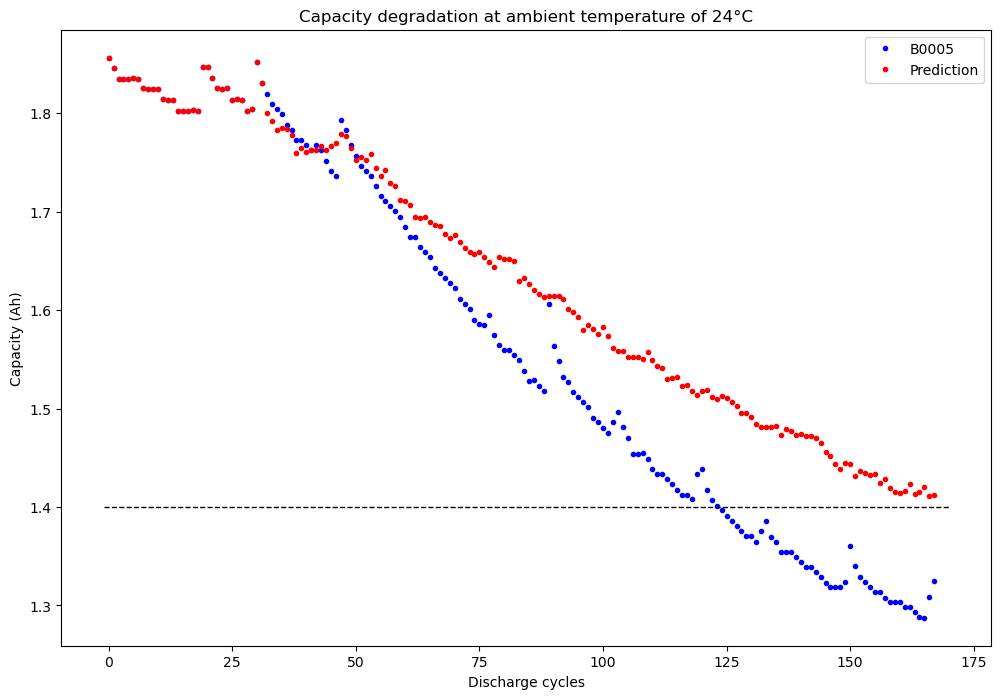

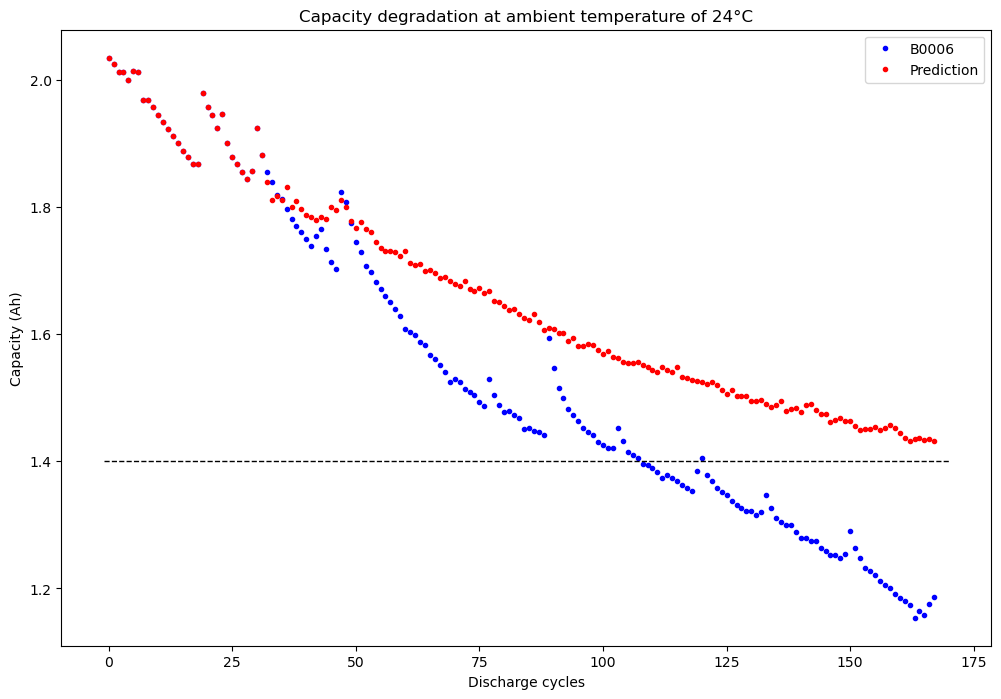

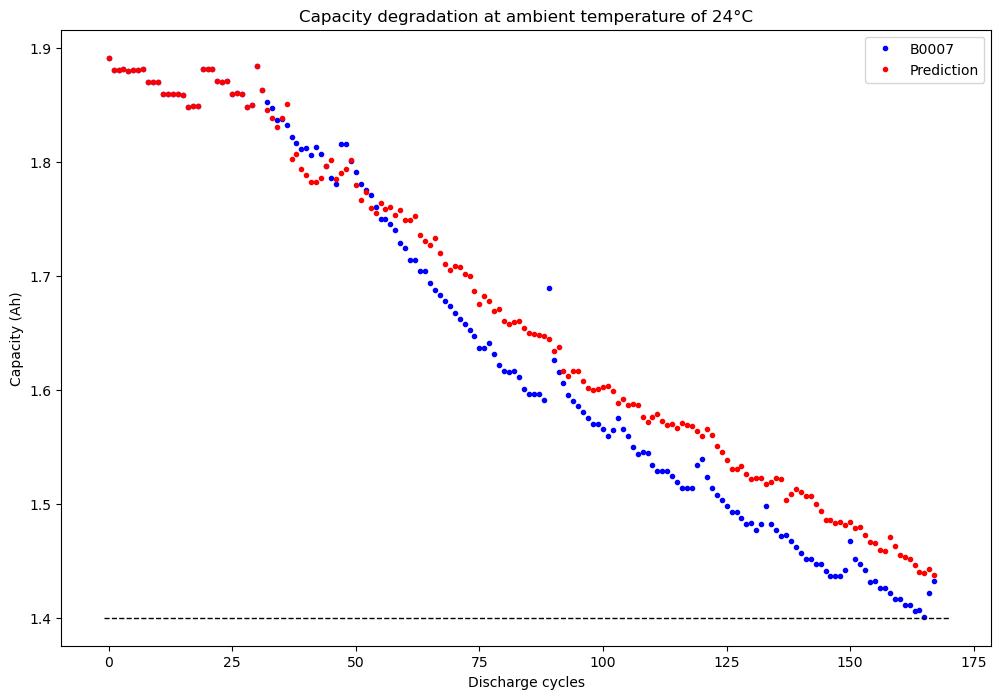

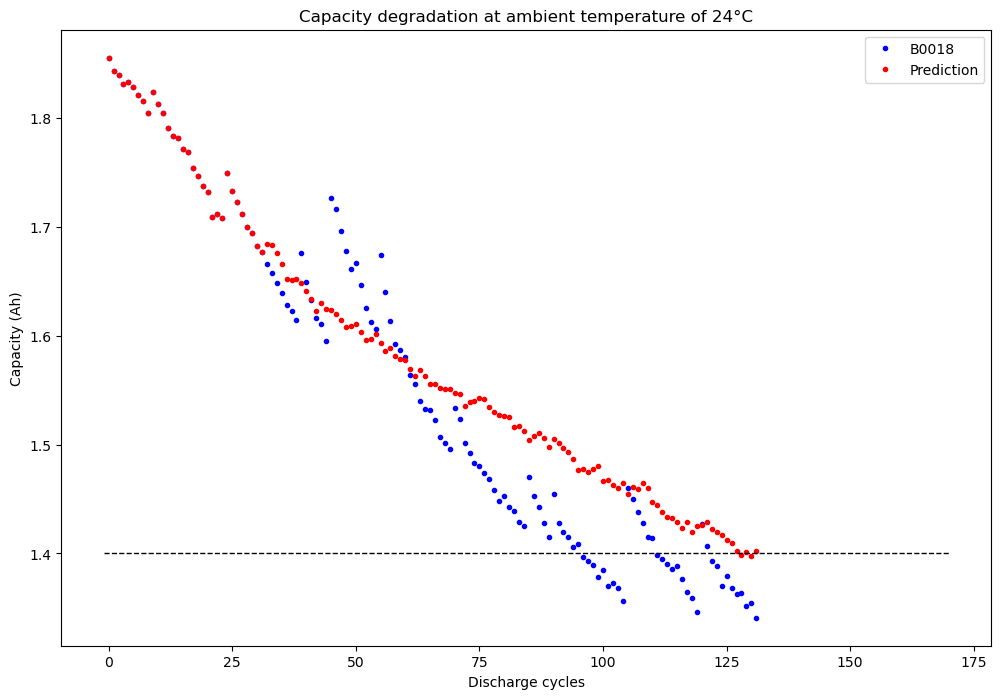

In [57]:
for name in data_dict.keys():
    train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)

    real = data_dict[name][1]
    prefix_x = data_dict[name][1][:window_size]
    decode_seq = model.decode(prefix_x,max_length=len(test_data))
    
    plot(name=name,
         real_data=real,
        pred_data=decode_seq)